In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from modules.wavenet import WaveNet
from modules.dvae import GFSQ, DVAEDecoder
import os
from torch.utils.tensorboard import SummaryWriter
import librosa
import torchaudio
from torch.utils.data import random_split
import logging
from torch.cuda.amp import autocast, GradScaler
from modules.feature_extractors import MelSpectrogramFeatures
from modules.discriminator import DynamicAudioDiscriminator,Discriminator,DynamicAudioDiscriminatorWithResidual

/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
# 设置日志级别为INFO
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.info(f"Use device: {device}")

INFO:root:Use device: mps


加载模型

In [5]:
model_params = {'WaveNet': 
    {'input_channels': 100, 'output_channels': 1024, 'residual_layers': 20, 'dilation_cycle': 4}, 
    'GFSQ': {'dim': 1024, 'levels': [16, 8, 5], 'G': 16, 'R': 2}, 
    'DVAEDecoder': {'idim': 1024, 'odim': 100, 'n_layer': 12, 'bn_dim': 128, 'hidden': 1024}, 
    'Discriminator': {}}

In [6]:
wavenet = WaveNet(**model_params["WaveNet"]).to(device)
gfsq = GFSQ(**model_params["GFSQ"]).to(device)
decoder = DVAEDecoder(**model_params["DVAEDecoder"]).to(device)

找到最新的模型并且加载权重

In [7]:
def convert_state_dict_to_float(state_dict):
    """
    将 state_dict 中的所有张量从 fp16 转换为 fp32
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        new_state_dict[k] = v.float()  # 将每个张量转换为float32
    return new_state_dict

In [8]:
import glob


checkpoint_files = glob.glob('checkpoint_epoch_*.pth')
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    wavenet.load_state_dict(convert_state_dict_to_float(checkpoint['wavenet_state_dict']))
    gfsq.load_state_dict(convert_state_dict_to_float(checkpoint['gfsq_state_dict']))
    decoder.load_state_dict(convert_state_dict_to_float(checkpoint['decoder_state_dict']))
    start_epoch = checkpoint['epoch']
    logger.info(f"load training from epoch {start_epoch}")
else:
    raise Exception("Not found checkpoint")

INFO:root:load training from epoch 5


# 准备数据并且转换成Mel频谱图

In [9]:
n_fft = 1024
hop_length = 256
win_length = None
sample_rate = 24000
n_mels = 100

In [10]:
import torchaudio


def load_mel_spectrogram(file_path, sample_rate=24000, n_mels=100, n_fft=1024, hop_length=256):
    mel_spectrogram = MelSpectrogramFeatures(
        sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    # 加载音频文件并转换为Mel谱图
    waveform, sr = torchaudio.load(file_path)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    mel_spectrogram = mel_spectrogram(waveform)
    return mel_spectrogram

In [11]:
file_path = '/private/tmp/VCTK-Corpus/wav48/p300/p300_001.wav'
mel_spectrogram = load_mel_spectrogram(
    file_path, sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length).to(device)
print(mel_spectrogram.shape)

torch.Size([1, 100, 217])


使用模型进行预测

In [12]:
print(wavenet.eval())
print(gfsq.eval())
print(decoder.eval())

WaveNet(
  (input_projection): ConvNorm(
    (conv): Conv1d(100, 512, kernel_size=(1,), stride=(1,))
  )
  (residual_layers): ModuleList(
    (0): ResidualBlock(
      (conv_layer): ConvNorm(
        (conv): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (output_projection): ConvNorm(
        (conv): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (1): ResidualBlock(
      (conv_layer): ConvNorm(
        (conv): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      )
      (output_projection): ConvNorm(
        (conv): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (2): ResidualBlock(
      (conv_layer): ConvNorm(
        (conv): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
      )
      (output_projection): ConvNorm(
        (conv): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (3): ResidualBlock(
      (conv_layer): ConvNorm(
       

In [13]:
with torch.no_grad(), autocast():
    features = wavenet(mel_spectrogram)
    _, quantized_features, _, _, quantized_indices = gfsq(features)
    print(f"quantized_features shape: {quantized_features.shape}")
    decoded_features = decoder(quantized_features)
print(f"origin shape: {mel_spectrogram.shape}")
print(f"decode shape: {decoded_features.shape}")

/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


quantized_features shape: torch.Size([1, 1024, 217])
origin shape: torch.Size([1, 100, 217])
decode shape: torch.Size([1, 100, 217])


## 打印二者的Mel频谱图

/var/folders/p3/yt773s8171n4tjq59pq7__km0000gn/T/ipykernel_56011/1921456771.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  plt.imshow(S.T.to('cpu'), origin='lower', aspect='auto', cmap='viridis')


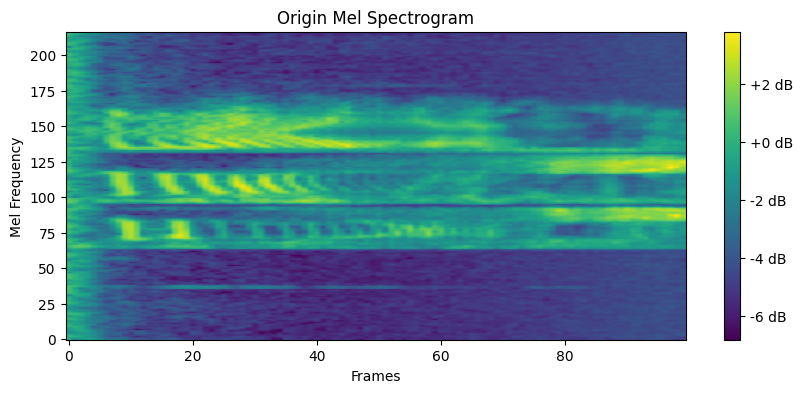

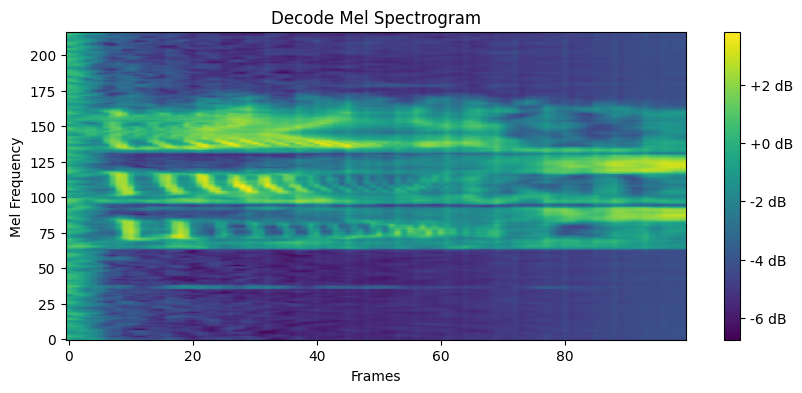

In [14]:
from matplotlib import pyplot as plt
import numpy as np
def plot_mel(S,sr = 24000,title = "Mel Spectrogram"):
    # 使用matplotlib绘制Mel频谱图
    plt.figure(figsize=(10, 4))
    plt.imshow(S.T.to('cpu'), origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Frames')
    plt.ylabel('Mel Frequency')
    plt.show()
plot_mel(mel_spectrogram,title = "Origin Mel Spectrogram")
plot_mel(decoded_features[0], title= "Decode Mel Spectrogram")

In [15]:
import torch
from IPython.display import Audio

from vocos import Vocos

model = Vocos.from_hparams("/private/tmp/ChatTTS/config/vocos.yaml").to(device='cpu').eval()
model.load_state_dict(torch.load("/private/tmp/ChatTTS/asset/Vocos.pt"))

def mel_to_audio(mel_spectrogram):
    """将 Mel 频谱图转换回音频信号"""
    mel_spectrogram = mel_spectrogram.to(device='cpu')
    with torch.no_grad():
        audio = model.decode(mel_spectrogram)
    return audio.to('cpu').numpy()

播放原始音频和解压出来的音频

In [16]:
audio_waveform = mel_to_audio(mel_spectrogram)
Audio(audio_waveform,rate=24000)

播放生成的音频

In [17]:
audio_waveform = mel_to_audio(decoded_features)
Audio(audio_waveform,rate=24000)

# 恢复chatTTS的语音数据

需要手动从chatTTS生成流程中保存下来

保存的变量有 `vq_feats(1,1024,timesteps)`

`inp (1,4,121)`

In [2]:
import torch

inp  = torch.load("inp.pt")
vq_feats = torch.load("vq_feats.pt")

print(f"inp shape: {inp.shape}")
print(f"vq_feats shape: {vq_feats.shape}")

inp shape: torch.Size([1, 4, 330])
vq_feats shape: torch.Size([1, 1024, 330])


restore_mel shape: torch.Size([1, 100, 330])


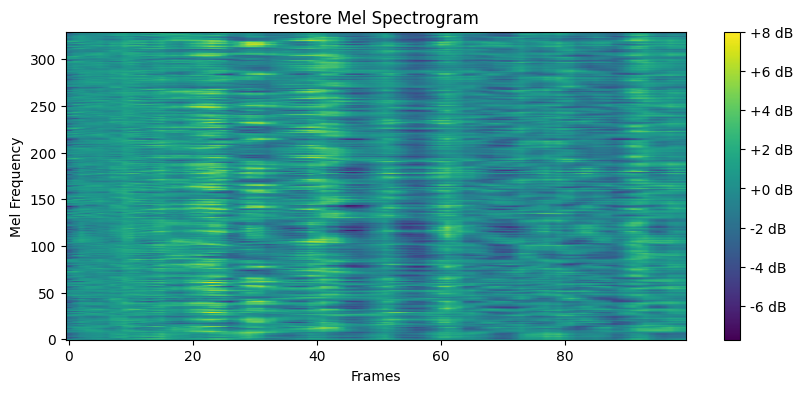

In [23]:
with torch.no_grad():
    vq_feats = vq_feats.to(device)
    restore_mel = decoder(vq_feats)
    print(f"restore_mel shape: {restore_mel.shape}")
plot_mel(restore_mel[0], title= "restore Mel Spectrogram")
audio_waveform = mel_to_audio(restore_mel)
Audio(audio_waveform,rate=24000)

In [53]:
print(gfsq)
print(decoder)

GFSQ(
  (quantizer): GroupedResidualFSQ(
    (rvqs): ModuleList(
      (0-15): 16 x ResidualFSQ(
        (project_in): Linear(in_features=64, out_features=3, bias=True)
        (project_out): Linear(in_features=3, out_features=64, bias=True)
        (layers): ModuleList(
          (0-1): 2 x FSQ(
            (project_in): Identity()
            (project_out): Identity()
          )
        )
      )
    )
  )
)
DVAEDecoder(
  (conv_in): Sequential(
    (0): Conv1d(1024, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(128, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (decoder_block): ModuleList(
    (0-11): 12 x ConvNeXtBlock(
      (dwconv): Conv1d(1024, 1024, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,), groups=1024)
      (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (pwconv1): Linear(in_features=1024, out_features=4096, bias=True)
      (act): GELU(approximate='none')
      (pwconv2)